In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/ilia/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [4]:
df_train = pd.read_csv('../train.csv', 
                       dtype={
                           'question1': np.str,
                           'question2': np.str
                       })
df_train['test_id'] = -1
df_test = pd.read_csv('../test.csv', 
                      dtype={
                          'question1': np.str,
                          'question2': np.str
                      })
df_test['id'] = -1
df_test['qid1'] = -1
df_test['qid2'] = -1
df_test['is_duplicate'] = -1

df = pd.concat([df_train, df_test])
df['question1'] = df['question1'].fillna('')
df['question2'] = df['question2'].fillna('')
df['uid'] = np.arange(df.shape[0])
df = df.set_index(['uid'])
print (df.dtypes)
del(df_train, df_test)

id               int64
is_duplicate     int64
qid1             int64
qid2             int64
question1       object
question2       object
test_id          int64
dtype: object


In [5]:
df['len1'] = df['question1'].str.len()
df['len2'] = df['question2'].str.len()

In [6]:
%%time
df['is_first_word_equal'] = df.apply(
    lambda r: int(r['question1'].split(' ')[0] == r['question2'].split(' ')[0]), axis=1)

CPU times: user 1min 50s, sys: 116 ms, total: 1min 50s
Wall time: 1min 50s


In [7]:
df['abs_diff_len1_len2'] = np.abs(df['len1'] - df['len2'])

In [8]:
ix_train = df['is_duplicate'] != -1
ix_test = df['is_duplicate'] == -1

In [9]:
from textblob import TextBlob
from textblob import Word

In [17]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/ilia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
def remove_stopwodrs(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in TextBlob(text).words if w.lower() not in stopwords]
    return content

In [21]:
%%time
q1 = []
for x in df.question1:
    q1.append(' '.join(set(remove_stopwodrs(x))))
df['q1_without_stopwords'] = q1

CPU times: user 21min 23s, sys: 25 s, total: 21min 48s
Wall time: 21min 48s


In [22]:
%%time
q2 = []
for x in df.question2:
    q2.append(' '.join(set(remove_stopwodrs(x))))
df['q2_without_stopwords'] = q2

CPU times: user 21min 31s, sys: 25.6 s, total: 21min 57s
Wall time: 21min 57s


In [76]:
### посмотреть отдельно общие глаголы и существительные, относительно кол-ва слов, глянуть на значимость
### check similarity

In [77]:
# df['unique_words_density'] = df.apply(
#    lambda r: r['unique_words_number'] / (r['len1'] + r['len2']), axis = 1)

In [23]:
def syn_words(text):
    syns = []
    for x in TextBlob(text).words:
        for synset in Word(x).synsets:
            syns.append(synset.name().split('.')[0])
    return syns

In [24]:
%%time
df['unique_syn'] = df.apply(
    lambda r: set(syn_words(r['q1_without_stopwords'])).intersection(set(syn_words(r['q2_without_stopwords']))), axis = 1)

CPU times: user 41min 19s, sys: 3.45 s, total: 41min 22s
Wall time: 41min 22s


In [25]:
df.to_csv('new_train.csv', index = False)

In [82]:
df.shape

(2750086, 14)

In [83]:
len(df['unique_syn'])

2750086

In [26]:
df1 = pd.read_csv('new_train.csv')

In [6]:
df1.shape

(2750086, 14)

In [27]:
data = df1.dropna()

In [39]:
data.shape

(2727367, 16)

In [28]:
eq_num = []
for x in data.unique_syn:
    eq_num.append(len(x))

In [29]:
data['equal_syn_number'] = eq_num

/home/ilia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
data.head()

,id,is_duplicate,qid1,qid2,question1,question2,test_id,len1,len2,is_first_word_equal,abs_diff_len1_len2,q1_without_stopwords,q2_without_stopwords,unique_syn,equal_syn_number,eq_syn_number
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,-1,66,57,1,9,invest india share step guide market,invest share step guide market,"{'guidebook', 'invest', 'parcel', 'measure', '...",327,2.658537
1,1,0,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,-1,51,88,1,37,Koh-i-Noor Kohinoor Diamond story,diamond would Koh-i-Noor Indian happen stole b...,"{'rhombus', 'ball_field', 'diamond', 'baseball...",56,0.402878
2,2,0,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,-1,73,59,1,14,connection using increase internet speed VPN,Internet increased hacking DNS speed,"{'amphetamine', 'travel_rapidly', 'increase', ...",103,0.780303
3,3,0,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,-1,50,65,0,15,solve lonely mentally,"Find 24,23 remainder divided math 23 24",set(),5,0.043478
4,4,0,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,-1,76,39,1,37,methane oxide dissolve sugar salt water one ca...,would salt water survive fish,"{'body_of_water', 'water_system', 'salt', 'uri...",94,0.817391


In [41]:
%%time
data['diff_len1_len2_without_stopwords'] = data.apply(
    lambda r: len(r['q1_without_stopwords']) - len(r['q2_without_stopwords']), axis = 1)

CPU times: user 1min 36s, sys: 388 ms, total: 1min 36s
Wall time: 1min 36s


/home/ilia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
def plot_real_feature(fname):
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(data.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(data.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(data.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=data.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=data.loc[ix_train], 
                   ax=ax4)
    plt.show()

In [37]:
ix_train = data['is_duplicate'] != -1
ix_test = data['is_duplicate'] == -1

In [33]:
data['eq_syn_number'] = data.apply(lambda r: r['equal_syn_number'] / (r['len1'] + r['len2']), axis = 1)

/home/ilia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Populating the interactive namespace from numpy and matplotlib


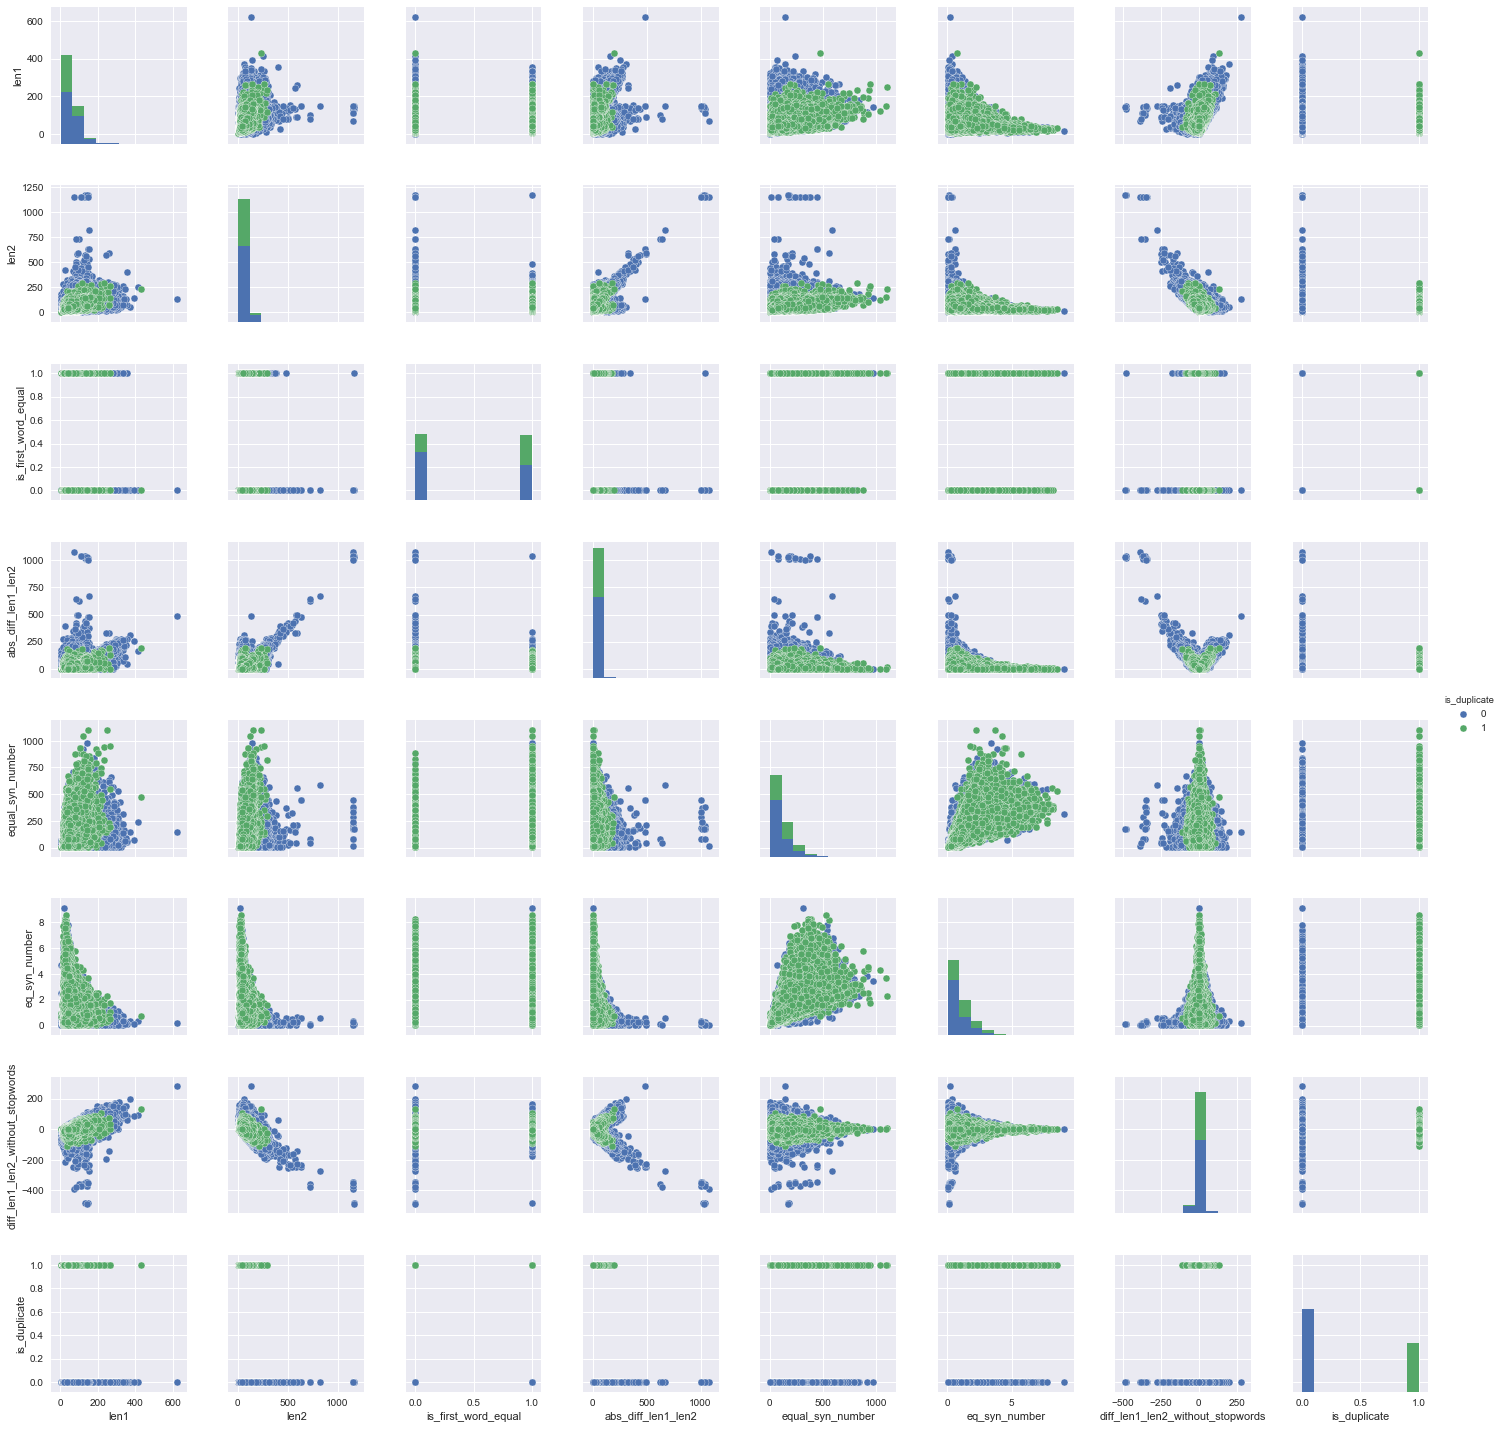

In [42]:
%pylab inline
sns.pairplot(data.loc[ix_train][data.columns[7:].tolist() + ['is_duplicate']], hue="is_duplicate")

In [ ]:
### bigrams ###

In [44]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

cv_char = CountVectorizer(ngram_range=(1, 3), analyzer='char')
ch_freq = np.array(cv_char.fit_transform(data['q1_without_stopwords'].tolist() + data['q2_without_stopwords'].tolist()).sum(axis=0))[0, :]

CPU times: user 6min 48s, sys: 15.8 s, total: 7min 4s
Wall time: 7min 22s


In [47]:
unigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 1])
ix_unigrams = np.sort(unigrams.values())
print ('Unigrams:', len(unigrams))
bigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 2])
ix_bigrams = np.sort(bigrams.values())
print ('Bigrams: ', len(bigrams))
trigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items() if len(k) == 3])
ix_trigrams = np.sort(trigrams.values())
print ('Trigrams:', len(trigrams))

ValueError: axis(=-1) out of bounds

NameError: name 'm_q1' is not defined